In [4]:
from numpy import mean
from numpy import std
import pandas as pd
from matplotlib import pyplot
from sklearn.model_selection import KFold
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from sklearn.model_selection import train_test_split


In [14]:
def load_dataset():
    # load dataset
    mnist_data = pd.read_csv("mnist_train.csv")
    # Find Traing and Test
    x_train, x_test, y_train, y_test = train_test_split(mnist_data.drop(["label"], axis=1), mnist_data[["label"]], test_size=0.20, random_state=42)
    
    # Conversion into Numpy
    y_train = y_train.to_numpy()
    x_train = x_train.to_numpy()
    x_test = x_test.to_numpy()
    y_test = y_test.to_numpy()
    
    # reshape dataset to have a single channel
    trainX = x_train.reshape((x_train.shape[0], 28, 28, 1))
    testX = x_test.reshape((x_test.shape[0], 28, 28, 1))
    
    # one hot encode target values
    trainY = to_categorical(y_train)
    testY = to_categorical(y_test)
    return trainX, trainY, testX, testY

x_train, y_train, x_test, y_test = load_dataset()

In [18]:
def prep_pixels(train, test):
	train_norm = train.astype('float32')
	test_norm = test.astype('float32')

	train_norm = train_norm / 255.0
	test_norm = test_norm / 255.0

	return train_norm, test_norm

x_train, x_test = prep_pixels(x_train, x_test)

In [22]:
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', 
                     kernel_initializer='he_uniform', 
                     input_shape=(28, 28, 1)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(10, activation='softmax'))
	# compile model
	opt = SGD(lr=0.01, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', 
                  metrics=['accuracy'])
	return model

model = define_model()

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 5408)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               540900    
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1010      
Total params: 542,230
Trainable params: 542,230
Non-trainable params: 0
_________________________________________________________________


In [28]:
def evaluate_model(dataX, dataY, n_folds=10):
	scores, histories = list(), list()
	# prepare cross validation
	kfold = KFold(n_folds, shuffle=True, random_state=1)
	# enumerate splits
	for train_ix, test_ix in kfold.split(dataX):
		# define model
		model = define_model()
		# select rows for train and test
		trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
		# fit model
		history = model.fit(trainX, trainY, epochs=20, batch_size=64, 
                            validation_data=(testX, testY), verbose=2)
		# evaluate model
		_, acc = model.evaluate(testX, testY, verbose=2)
		print('> %.3f' % (acc * 100.0))
		# stores scores
		scores.append(acc)
		histories.append(history)
	return scores, histories

In [29]:
def summarize_diagnostics(histories):
	for i in range(len(histories)):
		# plot loss
		pyplot.subplot(2, 1, 1)
		pyplot.title('Cross Entropy Loss')
		pyplot.plot(histories[i].history['loss'], color='blue', label='train')
		pyplot.plot(histories[i].history['val_loss'], color='orange', label='test')
		# plot accuracy
		pyplot.subplot(2, 1, 2)
		pyplot.title('Classification Accuracy')
		pyplot.plot(histories[i].history['accuracy'], color='blue', label='train')
		pyplot.plot(histories[i].history['val_accuracy'], color='orange', label='test')
	pyplot.show()
 
# summarize model performance
def summarize_performance(scores):
	# print summary
	print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))
	# box and whisker plots of results
	pyplot.boxplot(scores)
	pyplot.show()

In [30]:
def run_test_harness(x_train, y_train, x_test, y_test):
	# load dataset
	trainX, trainY, testX, testY = x_train, y_train, x_test, y_test
	# evaluate model
	scores, histories = evaluate_model(trainX, trainY)
    	# learning curves
	summarize_diagnostics(histories)
	# summarize estimated performance
	summarize_performance(scores)

Train on 43200 samples, validate on 4800 samples
Epoch 1/20
 - 10s - loss: 0.2338 - accuracy: 0.9289 - val_loss: 0.1055 - val_accuracy: 0.9683
Epoch 2/20
 - 9s - loss: 0.0856 - accuracy: 0.9753 - val_loss: 0.0810 - val_accuracy: 0.9740
Epoch 3/20
 - 10s - loss: 0.0583 - accuracy: 0.9836 - val_loss: 0.0622 - val_accuracy: 0.9806
Epoch 4/20
 - 11s - loss: 0.0425 - accuracy: 0.9876 - val_loss: 0.0527 - val_accuracy: 0.9842
Epoch 5/20
 - 13s - loss: 0.0325 - accuracy: 0.9910 - val_loss: 0.0509 - val_accuracy: 0.9842
Epoch 6/20
 - 13s - loss: 0.0258 - accuracy: 0.9931 - val_loss: 0.0494 - val_accuracy: 0.9848
Epoch 7/20
 - 14s - loss: 0.0205 - accuracy: 0.9947 - val_loss: 0.0491 - val_accuracy: 0.9856
Epoch 8/20
 - 14s - loss: 0.0154 - accuracy: 0.9963 - val_loss: 0.0532 - val_accuracy: 0.9833
Epoch 9/20
 - 15s - loss: 0.0129 - accuracy: 0.9969 - val_loss: 0.0458 - val_accuracy: 0.9837
Epoch 10/20
 - 14s - loss: 0.0101 - accuracy: 0.9979 - val_loss: 0.0449 - val_accuracy: 0.9852
Epoch 11/20

Epoch 5/20
 - 12s - loss: 0.0342 - accuracy: 0.9901 - val_loss: 0.0623 - val_accuracy: 0.9798
Epoch 6/20
 - 12s - loss: 0.0264 - accuracy: 0.9930 - val_loss: 0.0532 - val_accuracy: 0.9800
Epoch 7/20
 - 12s - loss: 0.0206 - accuracy: 0.9942 - val_loss: 0.0668 - val_accuracy: 0.9779
Epoch 8/20
 - 13s - loss: 0.0166 - accuracy: 0.9958 - val_loss: 0.0601 - val_accuracy: 0.9808
Epoch 9/20
 - 13s - loss: 0.0125 - accuracy: 0.9973 - val_loss: 0.0542 - val_accuracy: 0.9819
Epoch 10/20
 - 13s - loss: 0.0100 - accuracy: 0.9978 - val_loss: 0.0552 - val_accuracy: 0.9819
Epoch 11/20
 - 13s - loss: 0.0082 - accuracy: 0.9985 - val_loss: 0.0550 - val_accuracy: 0.9831
Epoch 12/20
 - 13s - loss: 0.0060 - accuracy: 0.9992 - val_loss: 0.0558 - val_accuracy: 0.9831
Epoch 13/20
 - 14s - loss: 0.0051 - accuracy: 0.9993 - val_loss: 0.0524 - val_accuracy: 0.9840
Epoch 14/20
 - 15s - loss: 0.0036 - accuracy: 0.9997 - val_loss: 0.0621 - val_accuracy: 0.9817
Epoch 15/20
 - 16s - loss: 0.0030 - accuracy: 0.9998 - 

Epoch 10/20
 - 13s - loss: 0.0093 - accuracy: 0.9983 - val_loss: 0.0579 - val_accuracy: 0.9840
Epoch 11/20
 - 13s - loss: 0.0079 - accuracy: 0.9987 - val_loss: 0.0565 - val_accuracy: 0.9829
Epoch 12/20
 - 13s - loss: 0.0062 - accuracy: 0.9991 - val_loss: 0.0593 - val_accuracy: 0.9846
Epoch 13/20
 - 12s - loss: 0.0049 - accuracy: 0.9994 - val_loss: 0.0629 - val_accuracy: 0.9835
Epoch 14/20
 - 12s - loss: 0.0037 - accuracy: 0.9997 - val_loss: 0.0600 - val_accuracy: 0.9848
Epoch 15/20
 - 12s - loss: 0.0033 - accuracy: 0.9995 - val_loss: 0.0620 - val_accuracy: 0.9846
Epoch 16/20
 - 12s - loss: 0.0030 - accuracy: 0.9997 - val_loss: 0.0608 - val_accuracy: 0.9846
Epoch 17/20
 - 12s - loss: 0.0023 - accuracy: 0.9998 - val_loss: 0.0629 - val_accuracy: 0.9850
Epoch 18/20
 - 12s - loss: 0.0021 - accuracy: 0.9997 - val_loss: 0.0655 - val_accuracy: 0.9842
Epoch 19/20
 - 12s - loss: 0.0017 - accuracy: 0.9999 - val_loss: 0.0643 - val_accuracy: 0.9852
Epoch 20/20
 - 12s - loss: 0.0016 - accuracy: 0.99

/Users/ag78400/opt/anaconda3/envs/AI_for_Healthcare/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.
/Users/ag78400/opt/anaconda3/envs/AI_for_Healthcare/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':


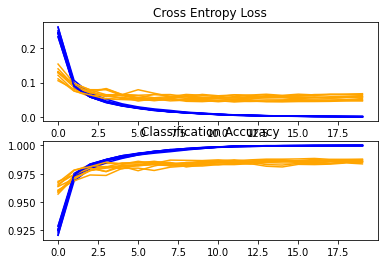

Accuracy: mean=98.613 std=0.117, n=10


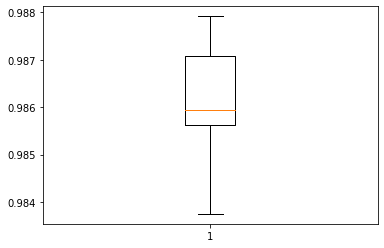

In [31]:
run_test_harness(x_train, y_train, x_test, y_test)